In [1]:
%load_ext autoreload
%autoreload 2
%env CUDA_VISIBLE_DEVICES=[]

env: CUDA_VISIBLE_DEVICES=[]


### red deer vocalizations
Source:
- http://www.tierstimmenarchiv.de/webinterface/contents/treebrowser.php

In [37]:
from pathlib2 import Path
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import re
import IPython
import librosa

In [3]:
from avgn_paper.signalprocessing import spectrogramming as sg

In [4]:
import pdb
from joblib import Parallel, delayed
n_jobs = 10
verbosity = 5

In [5]:
from tqdm.autonotebook import tqdm
from librosa.core.time_frequency import mel_frequencies
from avgn_paper.signalprocessing.spectrogramming_tf import spectrogram_tensorflow
from avgn_paper.utils.audio import load_wav, float32_to_int16, int16_to_float32, write_wav
from avgn_paper.visualization.spectrogram import visualize_spec, plot_spec
from avgn_paper.utils.general import HParams
from avgn_paper.signalprocessing.filtering import butter_bandpass_filter

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


### data locations

In [6]:
from glob import glob

In [8]:
DSLOC = Path('/mnt/cube/Datasets/animalsoundarchive/cervus_elaphus/')

In [10]:
fg_list = list(DSLOC.glob('*.mp3'))
len(fg_list), np.sort(fg_list)[-5:]

(88,
 array([PosixPath('/mnt/cube/Datasets/animalsoundarchive/cervus_elaphus/Cervus_elaphus_S1408_14_short.mp3'),
        PosixPath('/mnt/cube/Datasets/animalsoundarchive/cervus_elaphus/Cervus_elaphus_S1408_17_short.mp3'),
        PosixPath('/mnt/cube/Datasets/animalsoundarchive/cervus_elaphus/Cervus_elaphus_V1277_11_short.mp3'),
        PosixPath('/mnt/cube/Datasets/animalsoundarchive/cervus_elaphus/Cervus_elaphus_V1277_13_short.mp3'),
        PosixPath('/mnt/cube/Datasets/animalsoundarchive/cervus_elaphus/Cervus_elaphus_V2125_13_short.mp3')],
       dtype=object))

In [26]:
vocalization_lib = pd.read_excel(DSLOC.parent / 'recording_df.xlsx')
voc_df = vocalization_lib[(vocalization_lib.species == 'Cervus elaphus')  & (vocalization_lib.author == 'Tembrock, Günter')]
voc_df = voc_df[['filename', 'species', 'filename_ext', 'description', 'duration', 'notes', 'unique_identifier', 'bytes', 'recording_type']]

In [19]:
voc_df[:3]

filename         species subspecies locality  \
23   0025_Altai_Maral_Hirsch_Brunft  Cervus elaphus        NaN      NaN   
159       0168_Bucharahirsch_Brunft  Cervus elaphus        NaN      NaN   
160       0169_Bucharahirsch_Brunft  Cervus elaphus        NaN      NaN   

    administrative_area country state scenic_area  latitude  longitude  ...  \
23                  NaN     NaN   NaN         NaN       NaN        NaN  ...   
159                 NaN     NaN   NaN         NaN       NaN        NaN  ...   
160                 NaN     NaN   NaN         NaN       NaN        NaN  ...   

     species_group null_duration durations ico  \
23          mammal          True         0 NaN   
159         mammal          True         0 NaN   
160         mammal          True         0 NaN   

                                 filename_ext        last_modified  size  \
23   0025_Altai_Maral_Hirsch_Brunft_short.mp3  24-Jan-2014 12:21    247K   
159       0168_Bucharahirsch_Brunft_short.mp3  24-Jan-2014 12:22    277K   
160       0169_Bucharahirsch_Brunft_short.mp3  24-Jan-2014 12:22    169K   

     description_wavdf   bytes  \
23                      247000   
159                     277000   
160                     169000   

                                                   url  
23   http://www.tierstimmenarchiv.de/recordings/002...  
159  http://www.tierstimmenarchiv.de/recordings/016...  
160  http://www.tierstimmenarchiv.de/recordings/016...  

[3 rows x 47 columns]

In [40]:
names = [i.split('.')[0].split(':')[0].split(',')[0].split(' ')[0] for i in voc_df.description.values]
np.unique(names),len(np.unique(names))

(array(['Altai-Maral', 'Bruftrufe', 'Brunft', 'Brunft-Rufe', 'Brunftrufe',
        'Brunftschrei', 'Buchara-Hirsch', 'Bucharahirsch', 'Hirsch',
        'Isubra-Hirsch', 'Isubrahirsch', 'Rufe', 'Röhren',
        'Unvollständige', 'Wapiti', 'Weibliche', 'Weibliches',
        'Zwergwapiti'], dtype='<U14'), 18)

In [45]:
def prepare_mel_matrix(hparams, return_numpy=True):
    # create a filter to convolve with the spectrogram
    mel_matrix = tf.signal.linear_to_mel_weight_matrix(
        num_mel_bins=hparams.num_mel_bins,
        num_spectrogram_bins=int(hparams.n_fft / 2) + 1,
        sample_rate=rate,
        lower_edge_hertz=hparams.mel_lower_edge_hertz,
        upper_edge_hertz=hparams.mel_upper_edge_hertz,
        dtype=tf.dtypes.float32,
        name=None,
    )
    
    # gets the center frequencies of mel bands
    mel_f = mel_frequencies(
        n_mels=hparams.num_mel_bins + 2,
        fmin=hparams.mel_lower_edge_hertz,
        fmax=hparams.mel_upper_edge_hertz,
    )

    # Slaney-style mel is scaled to be approx constant energy per channel (from librosa)
    enorm = tf.dtypes.cast(
        tf.expand_dims(
            tf.constant(
                2.0 / (mel_f[2 : hparams.num_mel_bins + 2] - mel_f[: hparams.num_mel_bins])
            ),
            0,
        ),
        tf.float32,
    )

    mel_matrix = tf.multiply(mel_matrix, enorm)
    mel_matrix = tf.divide(mel_matrix, tf.reduce_sum(mel_matrix, axis=0))
    if return_numpy:
        return mel_matrix.numpy()
    else:
        return mel_matrix
    
rate = 22050
win_length_ms = 10
hop_length_ms = 2
print(win_length_ms / 1000 * rate)
print(hop_length_ms / 1000 * rate)

hparams = HParams(
    # spectrogramming
    win_length=int(rate / 1000 * win_length_ms),
    n_fft=1024,
    hop_length=int(rate / 1000 * hop_length_ms),
    ref_level_db=20,
    min_level_db=-60,
    preemphasis=0.97,
    # mel scaling
    num_mel_bins=64,
    mel_lower_edge_hertz=1000,
    mel_upper_edge_hertz=11024,
    # inversion
    power=1.5,  # for spectral inversion
    griffin_lim_iters=50,
    pad=True,
    #
)
mel_matrix = prepare_mel_matrix(hparams)

220.5
44.1


In [48]:
import warnings
warnings.filterwarnings('ignore')

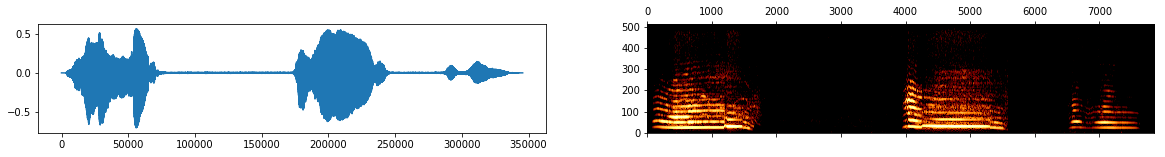

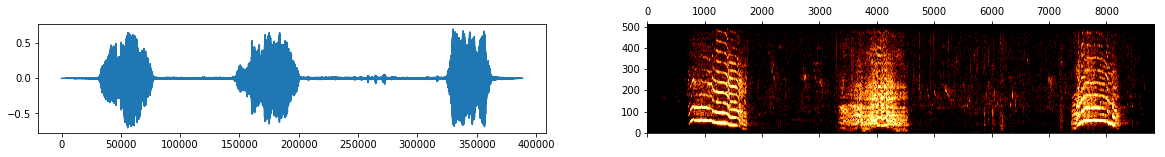

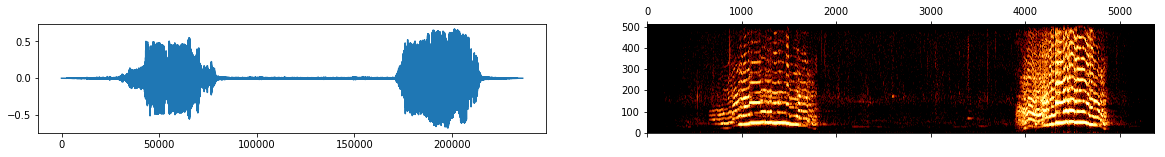

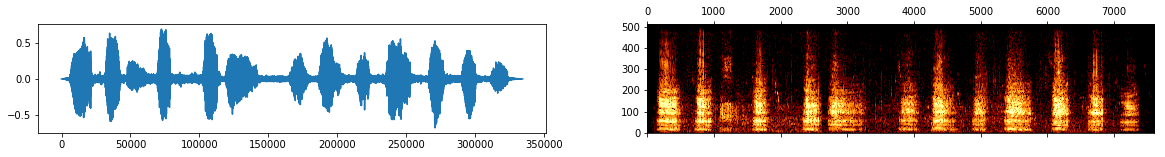

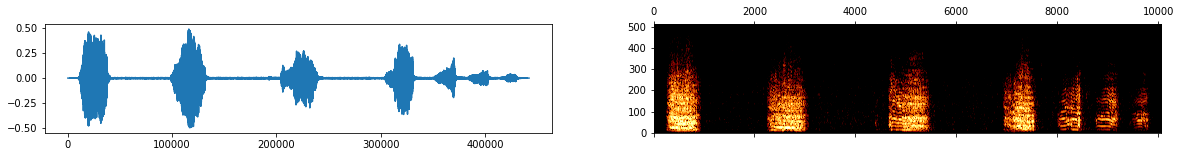

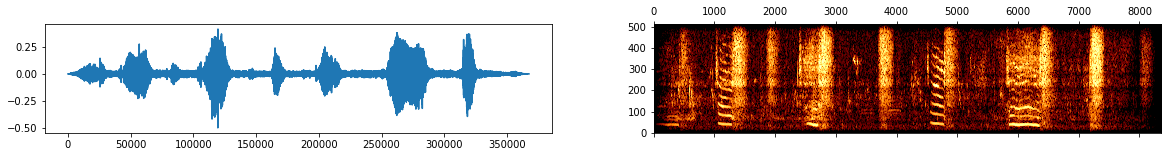

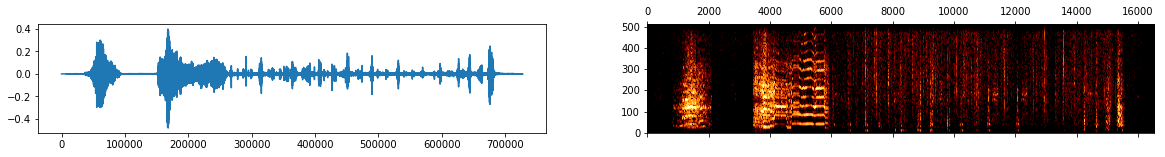

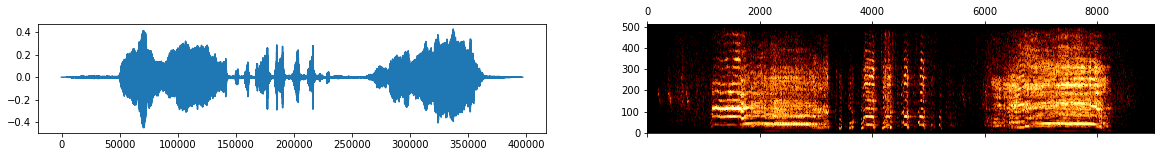

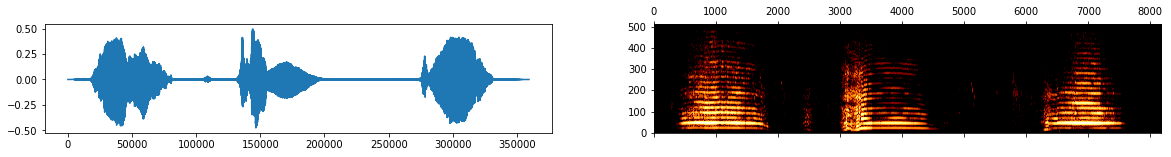

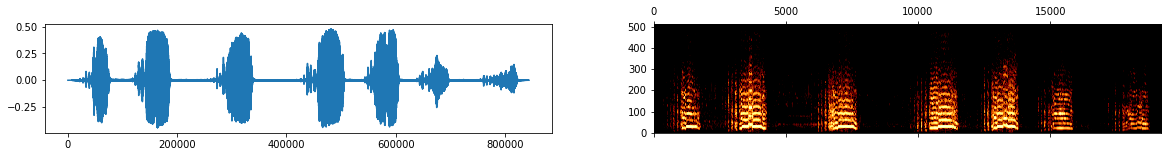

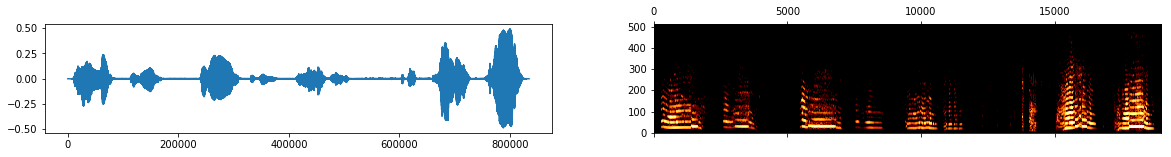

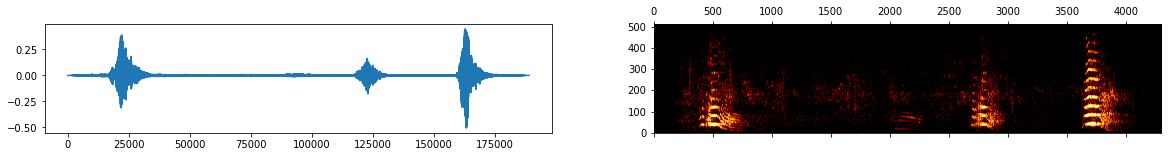

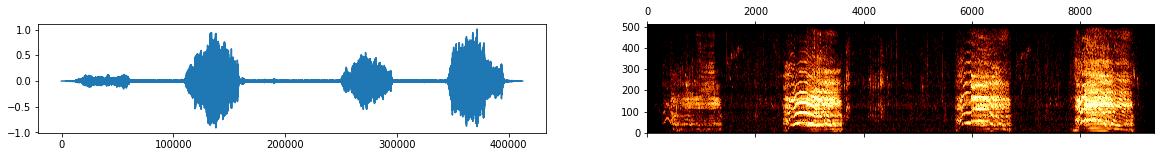

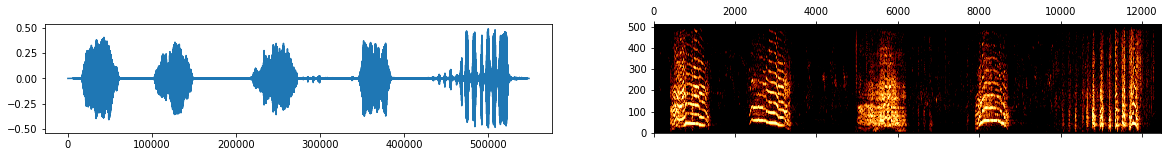

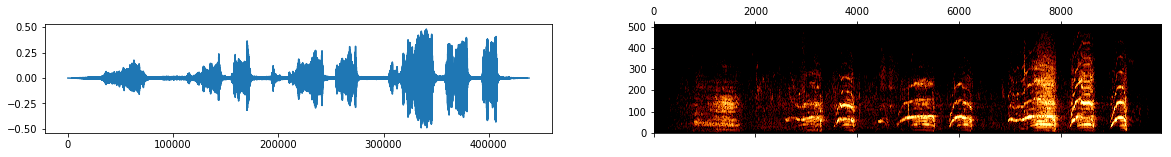

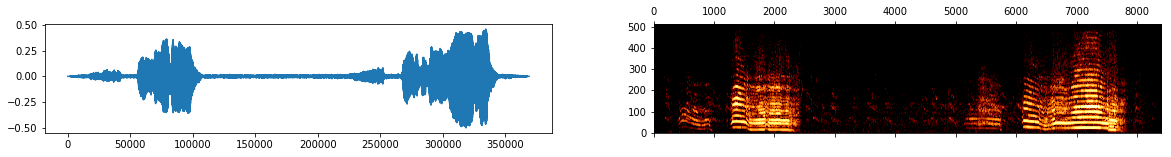

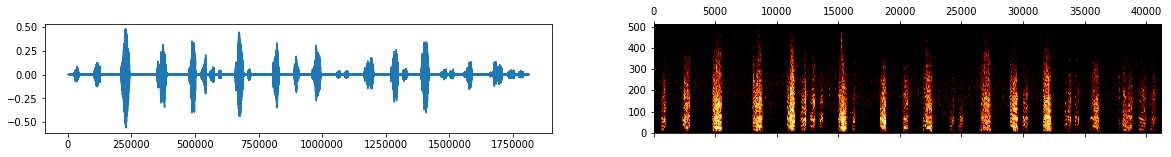

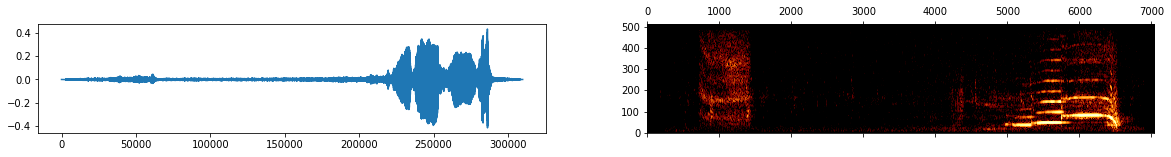

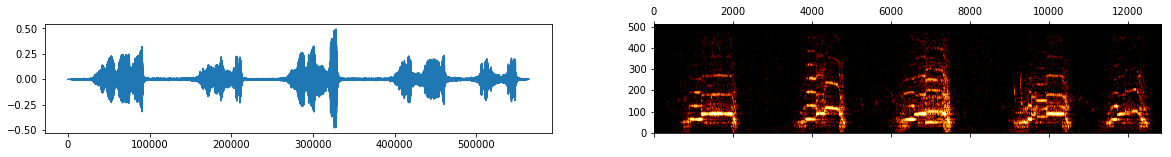

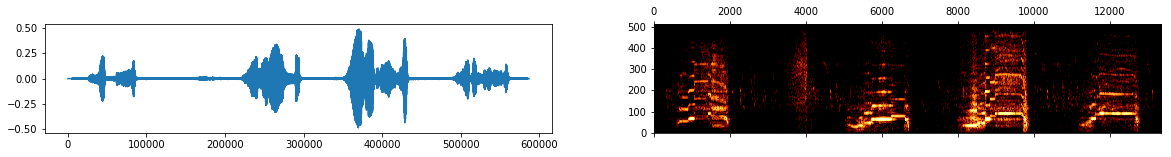

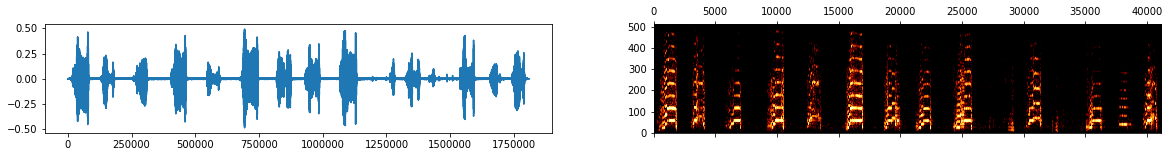

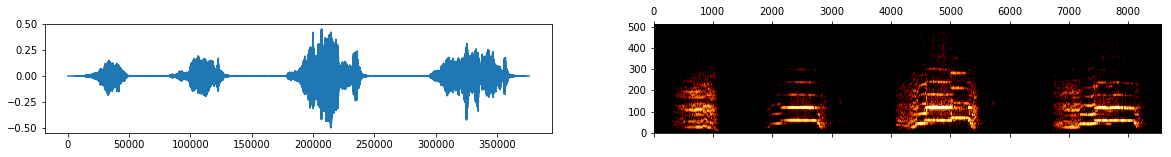

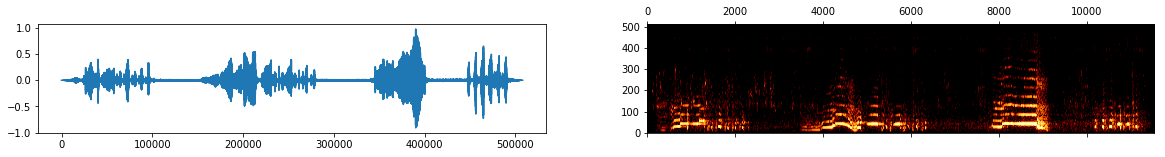

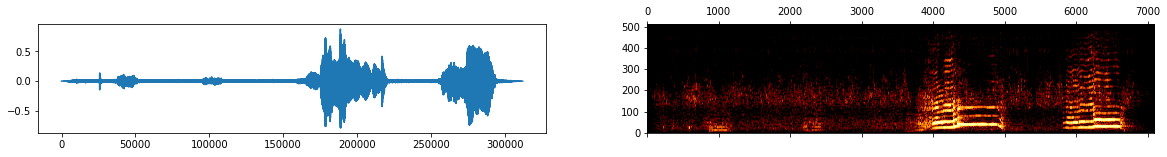

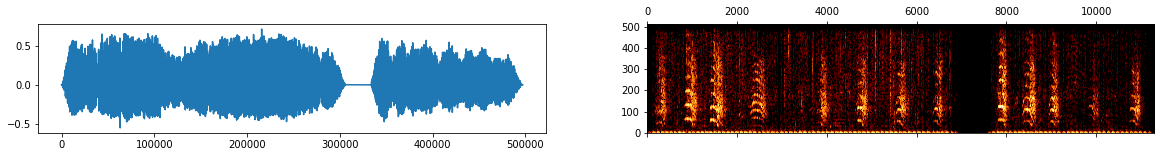

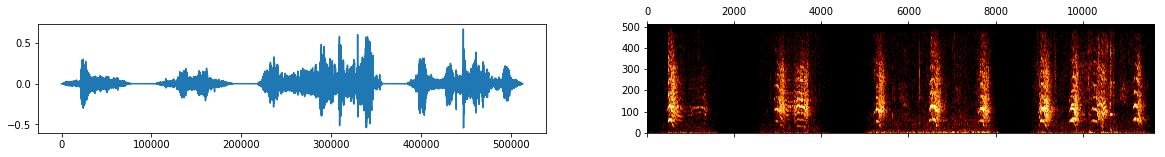

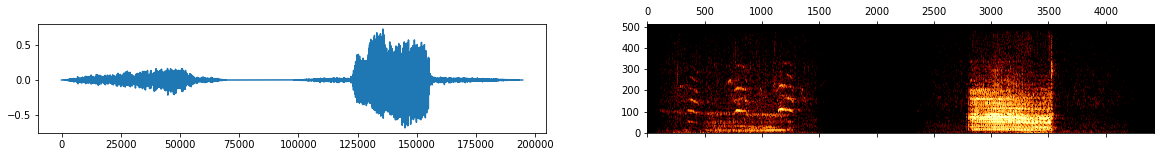

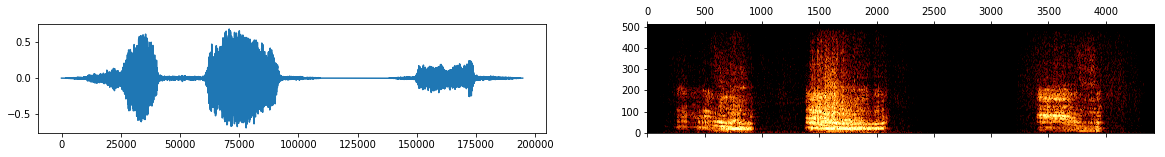

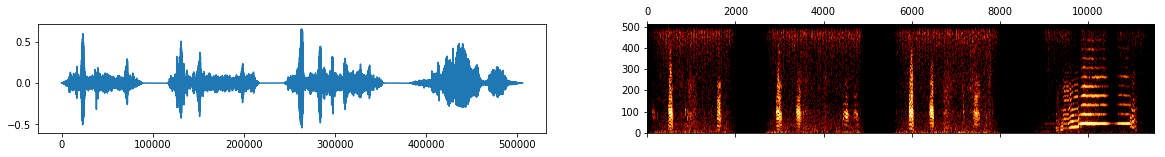

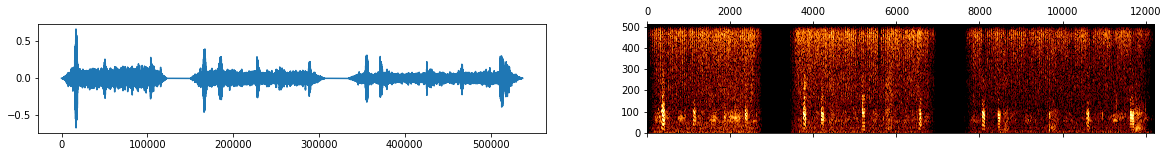

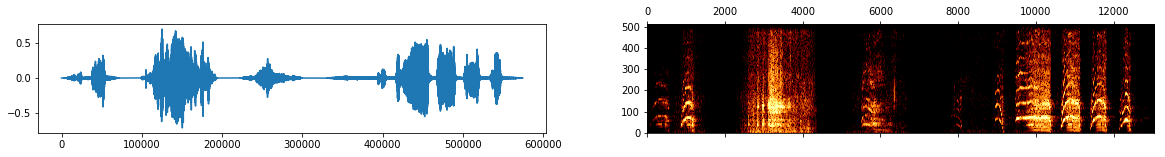

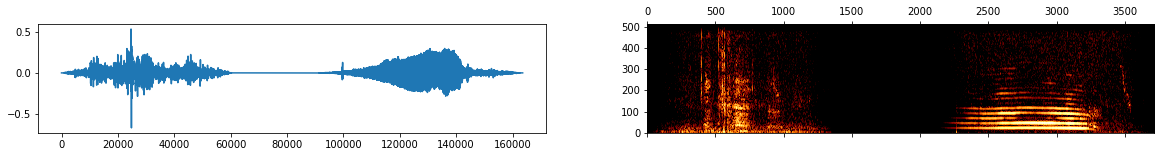

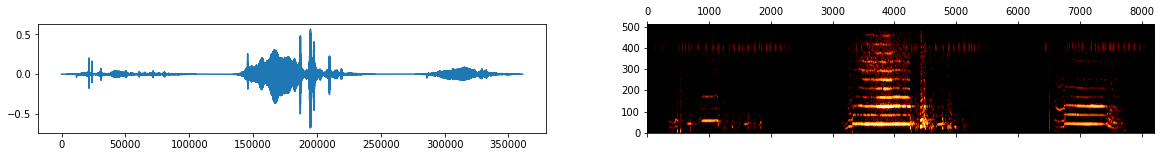

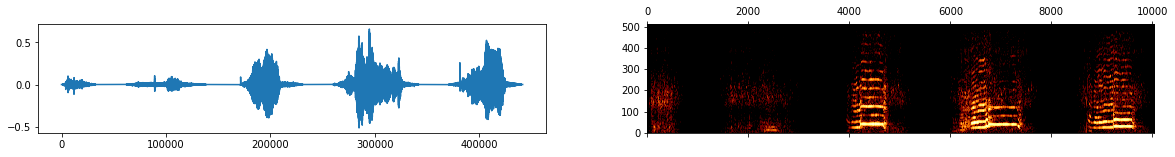

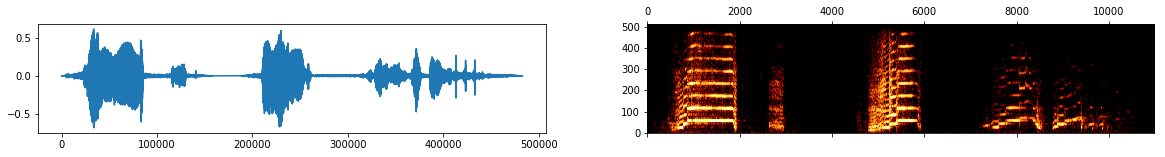

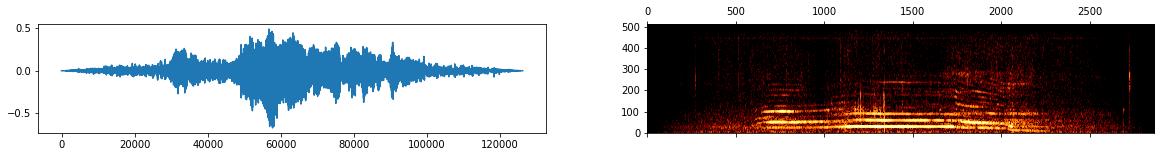

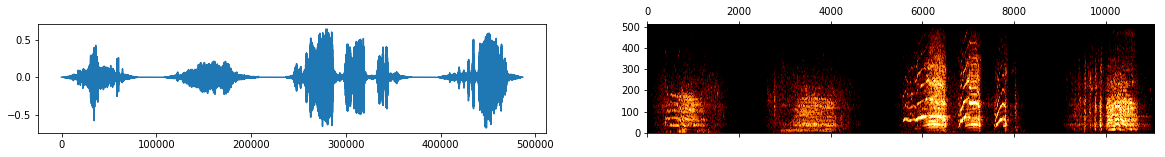

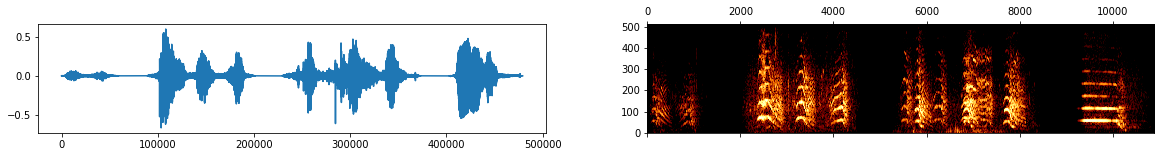

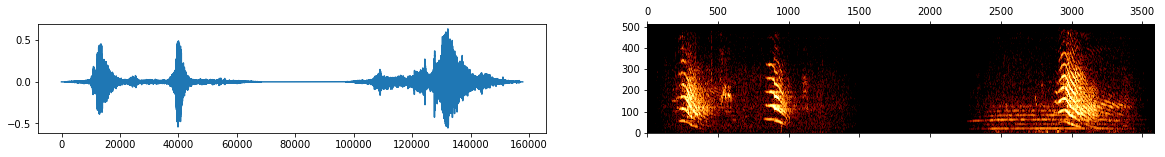

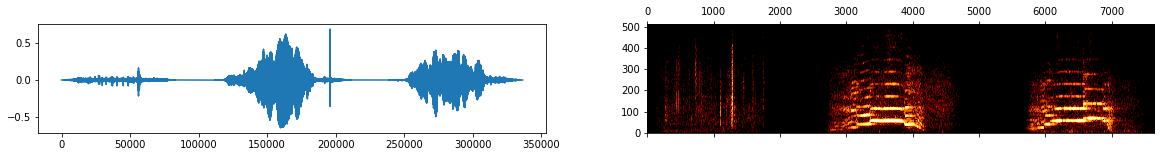

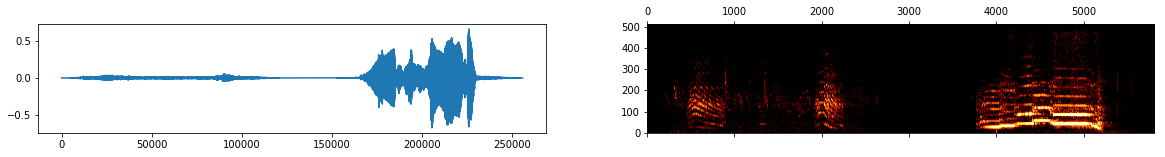

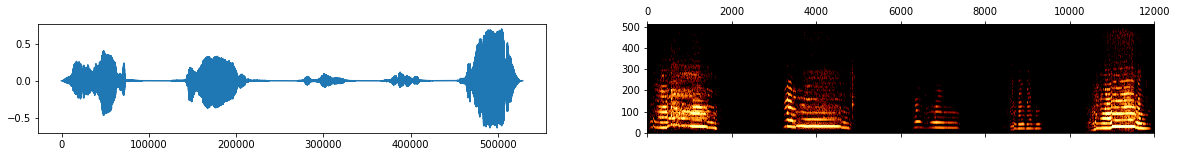

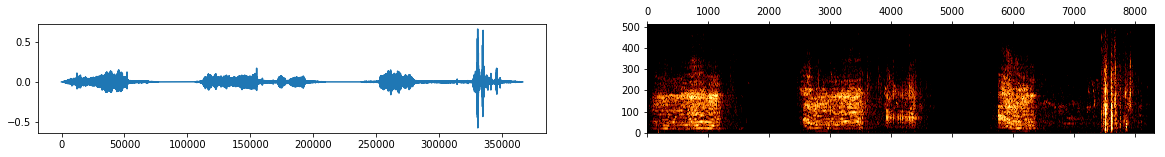

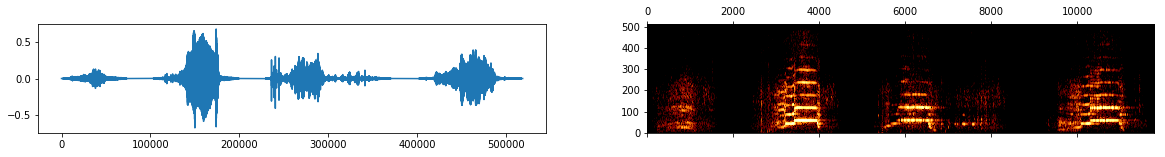

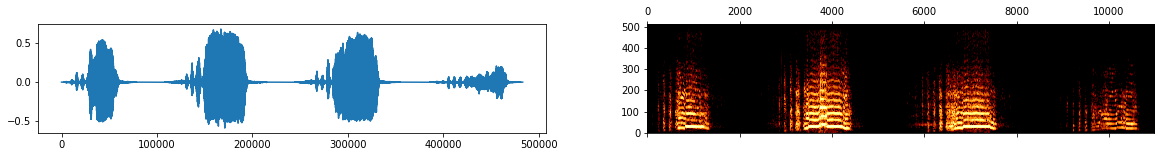

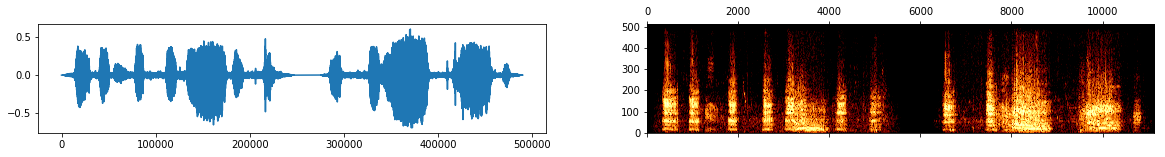

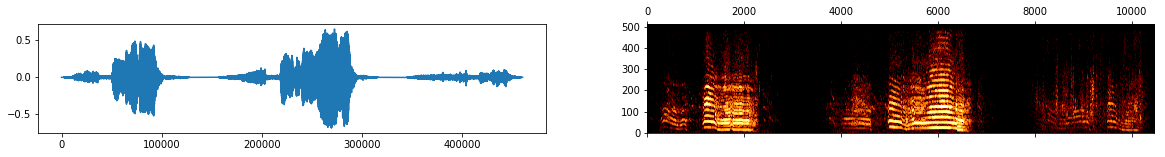

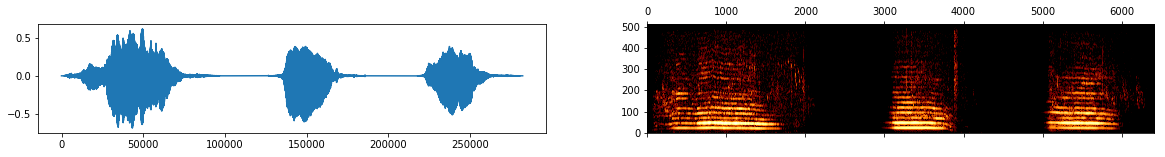

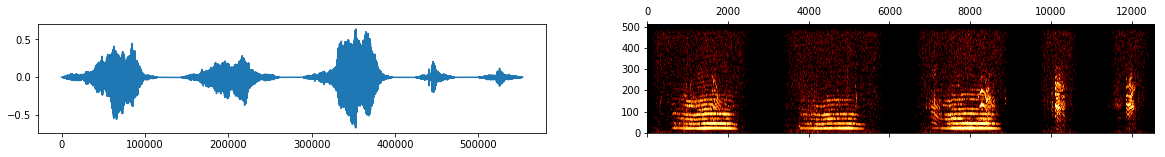

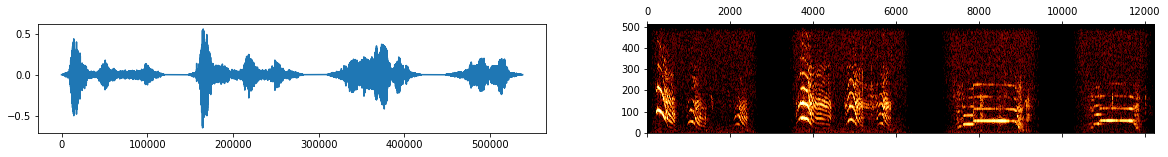

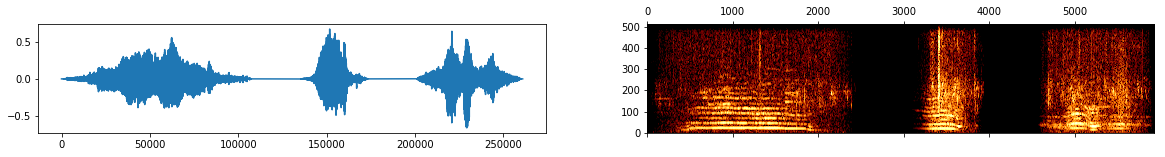

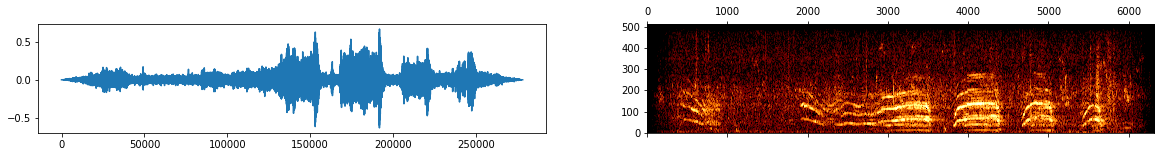

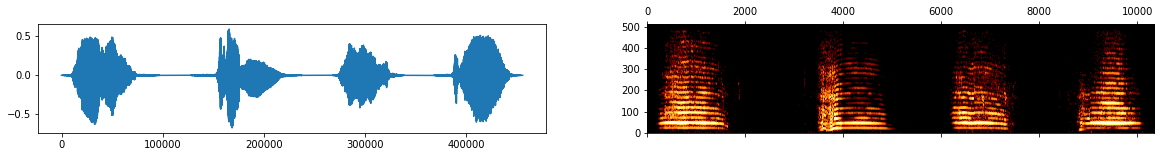

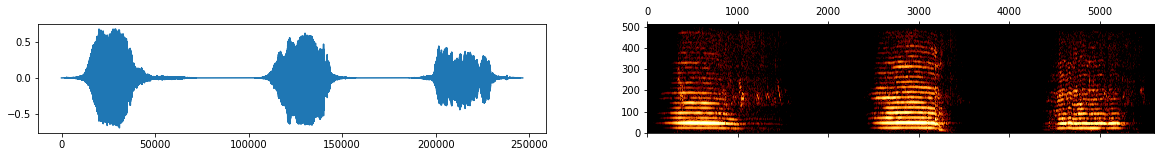

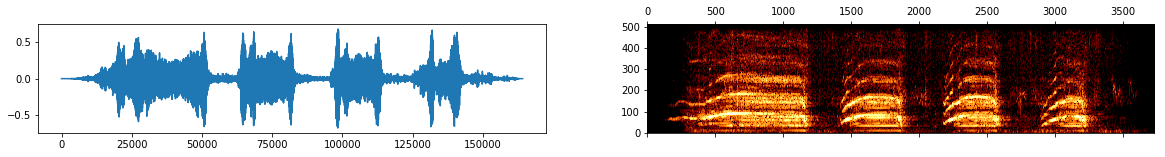

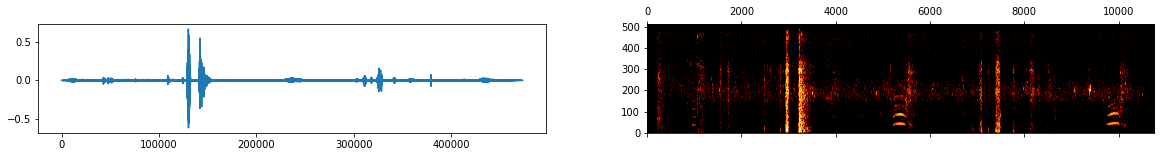

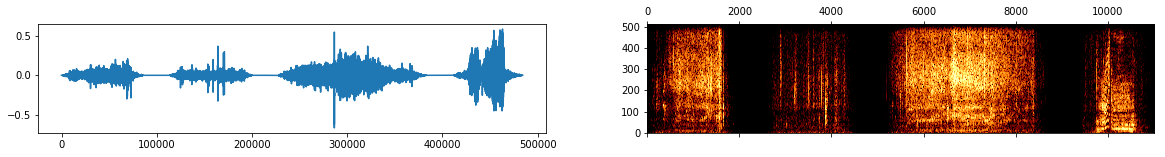

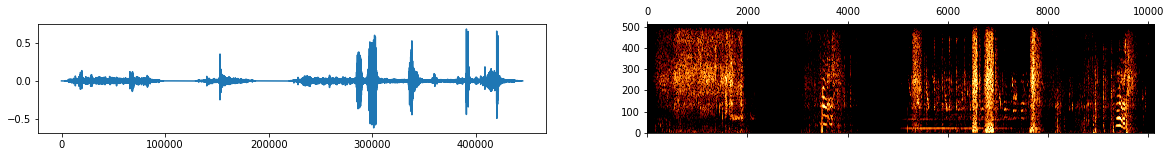

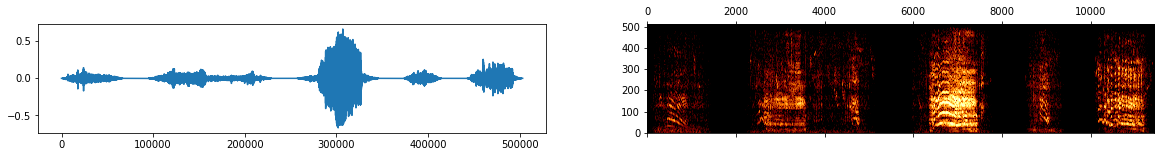

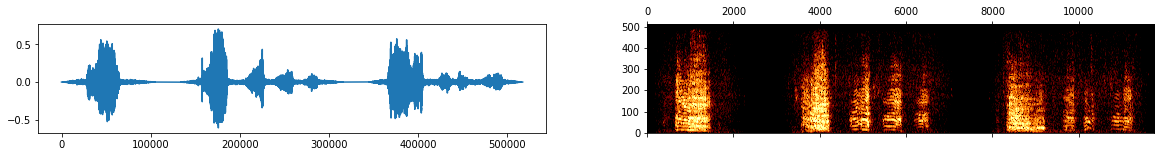

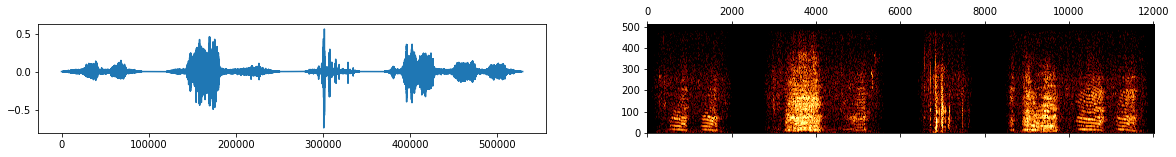

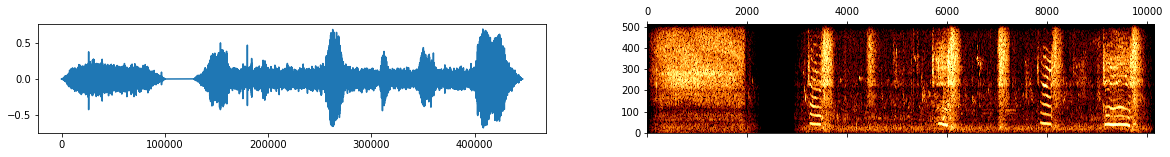

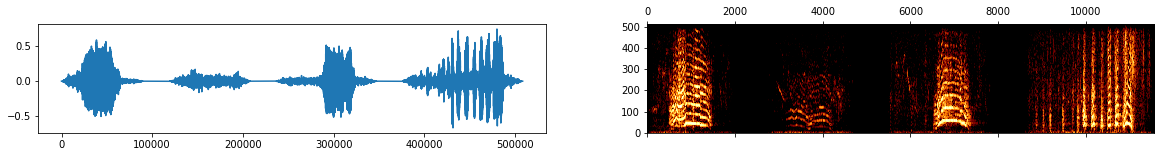

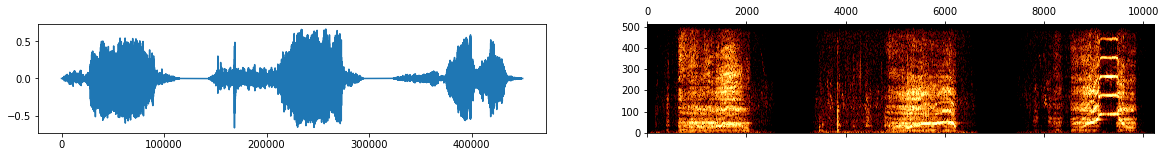

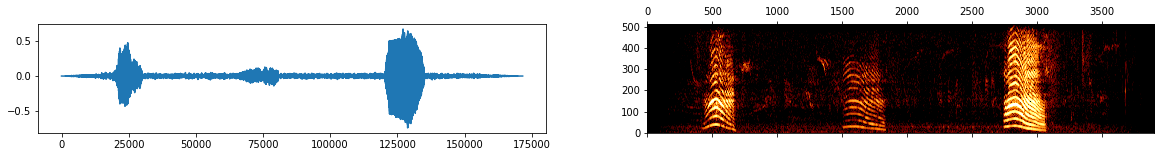

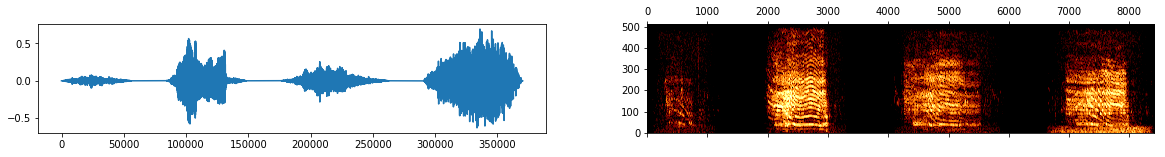

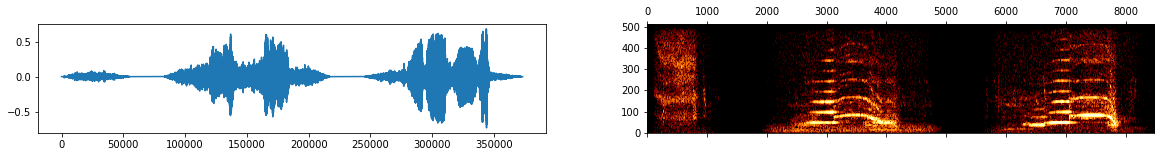

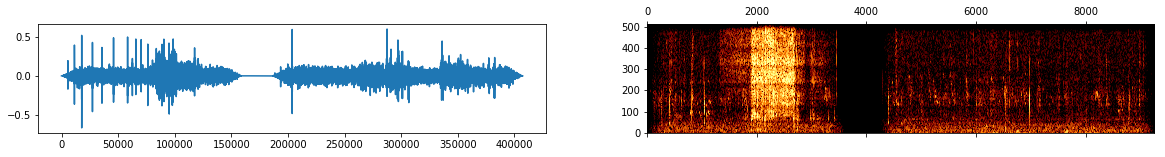

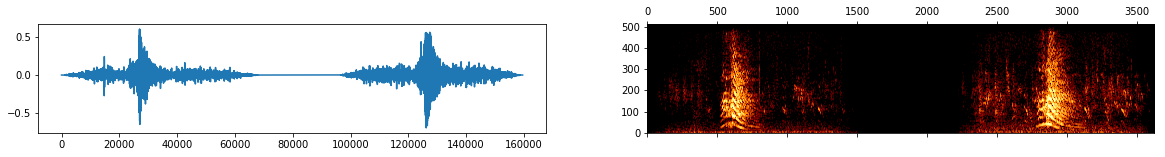

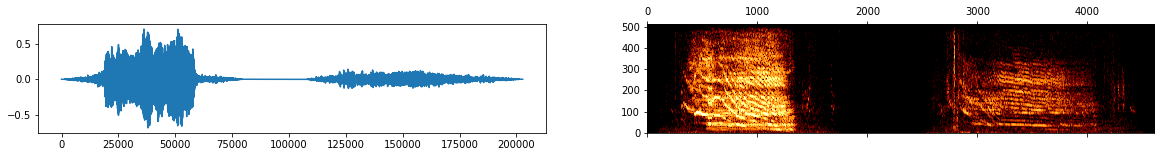

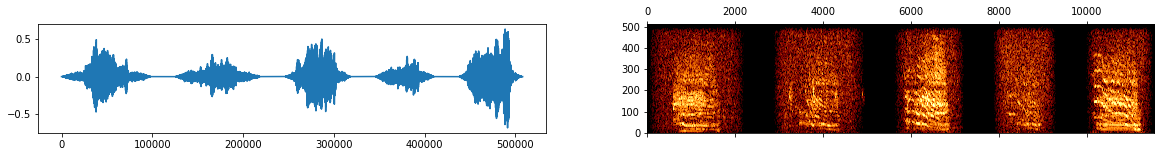

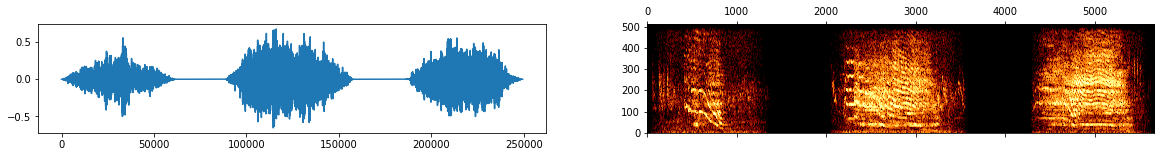

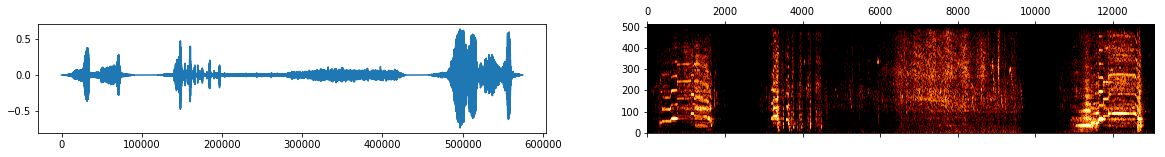

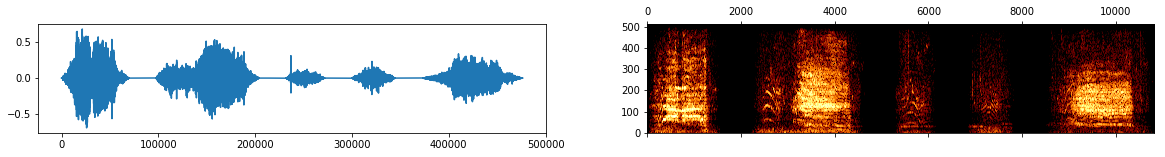

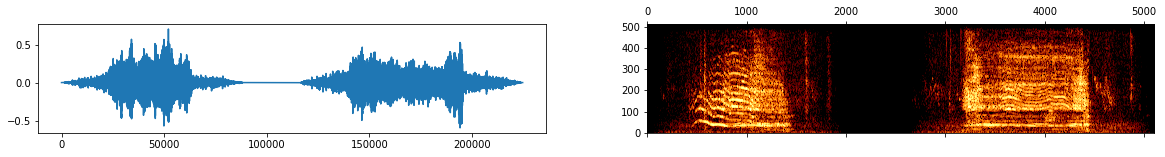

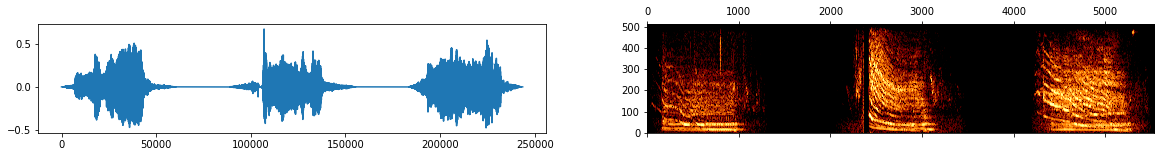

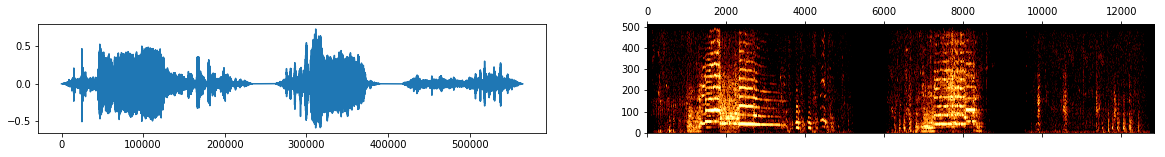

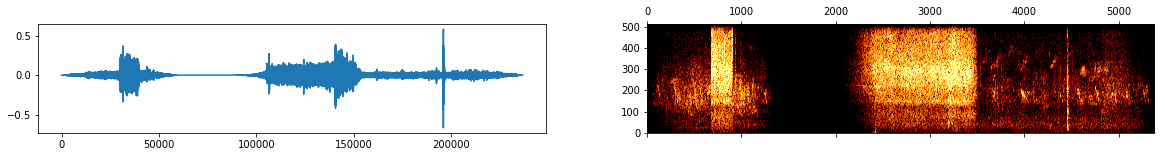

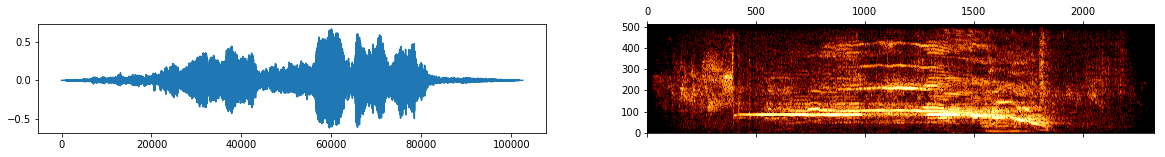

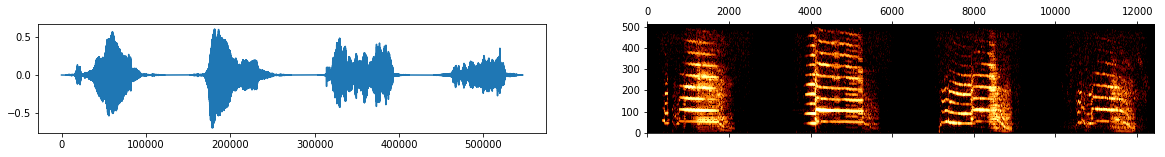

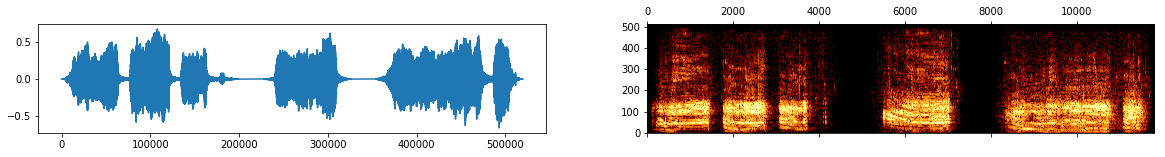

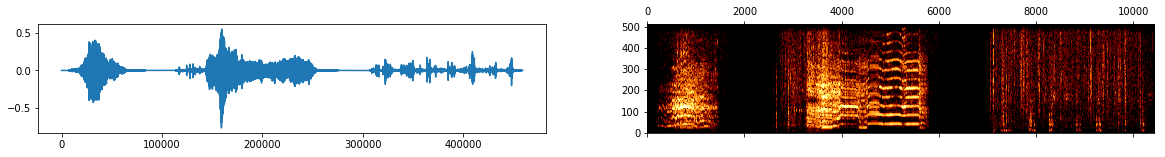

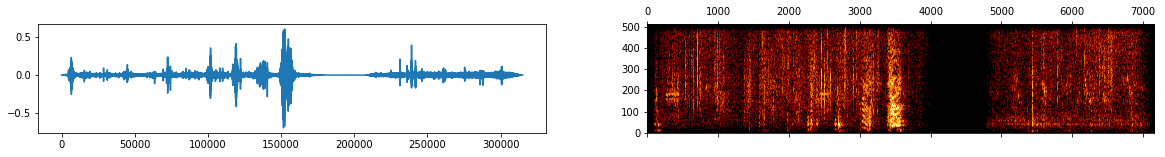

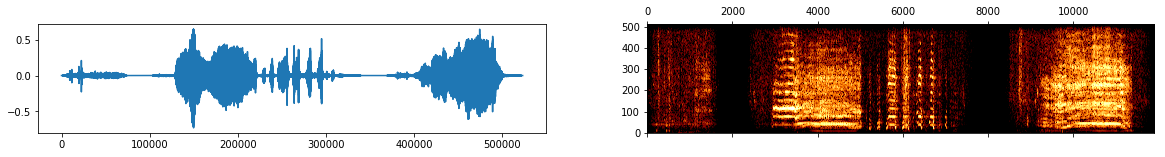

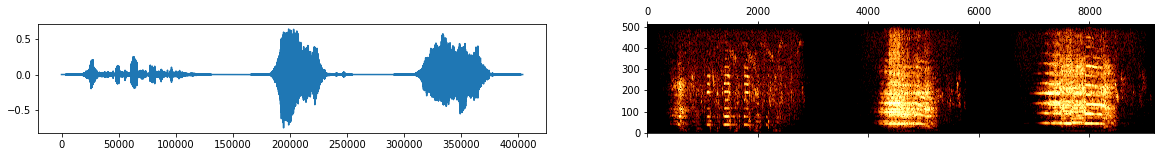

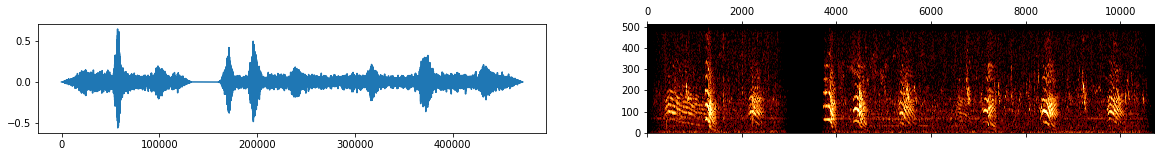

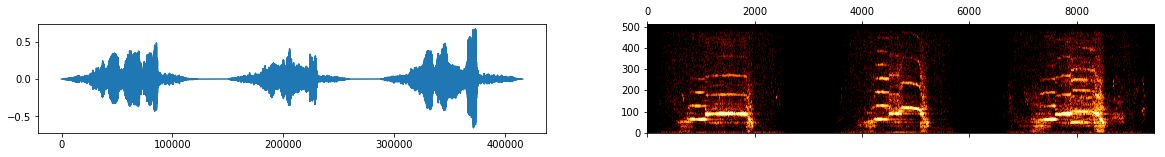

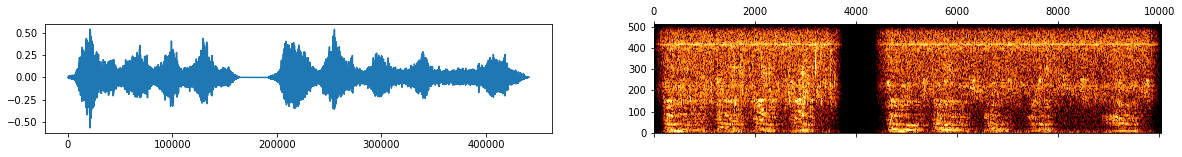

In [49]:
for idx, row in tqdm(voc_df.iterrows()):
    print(row.description.split('.')[0].split(':')[0].split(',')[0].split(' ')[0])
    mp3_path = np.array(fg_list)[row.filename_ext == np.array([i.name for i in fg_list])][0]
    y, sr = librosa.load(mp3_path)
    spectrogram = sg.spectrogram(y, hparams)
    
    fig, axs = plt.subplots(ncols=2, figsize=(20,2))
    axs[0].plot(y)
    axs[1].matshow(spectrogram, origin='lower', aspect='auto', cmap = plt.cm.afmhot)
    plt.show()
    